In [3]:
from tensorflow.keras import layers, models, backend, utils, metrics, preprocessing, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from PIL import Image
from wand.image import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics as skmetrics
import numpy as np
import seaborn as sns
import os
import pandas as pd
import glob
import errno
import scipy
from scipy import ndimage
import imageio


In [37]:
DIR_PREFIX  = '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'

def load_dataset(path):
    dataset = {"image_path":[],"img_status":[],"where":[]}
    for status in os.listdir(path):
        for image in glob.glob(path+"/"+status+"/"+"*.jpg"):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append("train")
    dataset = pd.DataFrame(dataset)
    dataset.value_counts("img_status")
    real = dataset.value_counts("img_status")[1]
    fake = dataset.value_counts("img_status")[0]

    print(f"Real: {real},\nFake: {fake}\n")
    sns.countplot(dataset["img_status"])
    plt.show()
    return dataset

def view_dataset(dataset):
    plt.figure(figsize = (14,10))
    for i in range(9):
        random = np.random.randint(1,len(dataset))
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
        plt.title(dataset.loc[random, "img_status"], size = 10) 
        plt.xticks([])
        plt.yticks([])

    plt.show()
    
def predict(img_path):
    input_arr = []
    count = 0
#     img_path = img_path.replace(DIR_PREFIX,'./output/')
    img = Image(filename = img_path)
    # Clone the image in order to process
    img.transform_colorspace('gray')
    img.edge(radius=2)
    img.save(filename='./output/my_test.png')
    image = preprocessing.image.load_img(
        './output/my_test.png', grayscale=False, color_mode="rgb", target_size=(256, 256, 3)
    )
    i = preprocessing.image.img_to_array(image)
    input_arr = np.array([i])
    predictions = model.predict(input_arr)
    return predictions[0]

def predict_dataset(dataset):
    plt.figure(figsize = (14,10))
    for i in range(9):
        random = np.random.randint(1,len(dataset))
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
        predicted = predict(dataset.loc[random,"image_path"]);
        plt.title(f"{dataset.loc[random, 'img_status']} accuracy: {predicted}", size = 10) 
        plt.xticks([])
        plt.yticks([])
    

def convert_to_edge(dir_name='train'):
    try:
        os.mkdir('./output/'+dir_name)
        os.mkdir('./output/'+dir_name+'/fake')
        os.mkdir('./output/'+dir_name+'/real')
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass
    i = 0
    print('data processed for '+dir_name)
    for filename in os.listdir(DIR_PREFIX+dir_name):
        f = os.path.join(DIR_PREFIX+dir_name, filename)
        # checking if it is a file
        if os.path.isdir(f):
            convert_to_edge(dir_name+'/'+filename)
        else:
            i = i+1
            with Image(filename = f) as img:
                # Clone the image in order to process
                img.transform_colorspace('gray')
                img.edge(radius=2)
                img.save(filename=f.replace(DIR_PREFIX,'./output/'))
            print(i, end='\r')
            
try:
    os.mkdir('./output')
except OSError as exc:
    pass

Real: 50000,
Fake: 50000



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


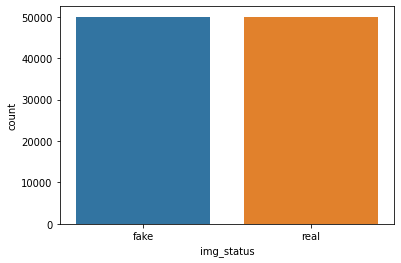

In [8]:
path  = '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'
train_dataset = load_dataset(path)

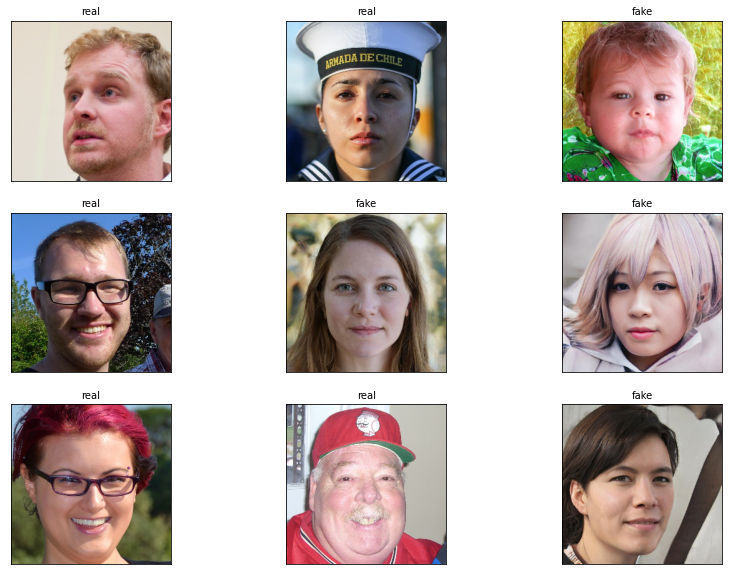

In [9]:
view_dataset(train_dataset)

In [10]:
convert_to_edge('train')
convert_to_edge('valid')
# convert_to_edge('test')

data processed for train
data processed for train/fake
data processed for train/real
data processed for valid
data processed for valid/fake
data processed for valid/real


Real: 50000,
Fake: 50000



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


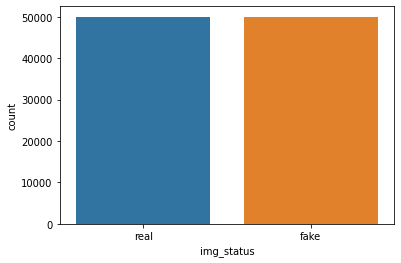

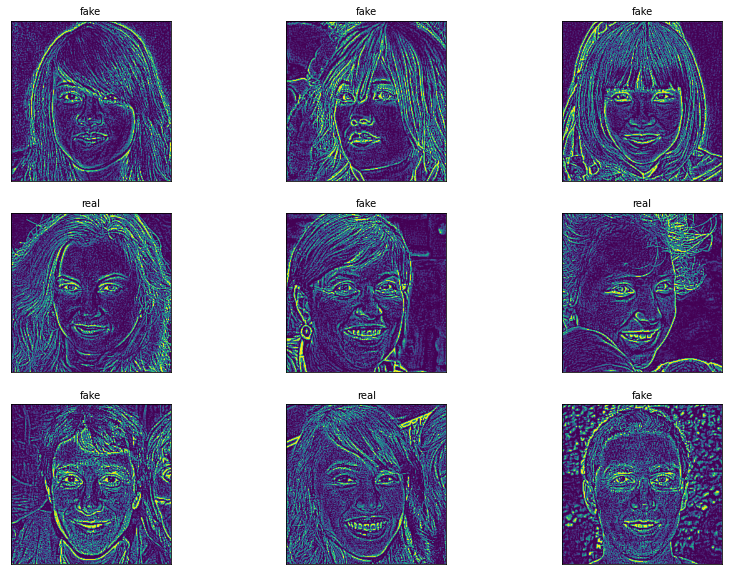

In [11]:
path  = './output/train'
train_dataset_preprocessed = load_dataset(path)
view_dataset(train_dataset_preprocessed)

In [28]:
base_path = './output/'
train_flow = preprocessing.image_dataset_from_directory(
    './output/train',
    image_size=(256, 256),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
test_flow = preprocessing.image_dataset_from_directory(
    '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test',
    image_size=(256, 256),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
valid_flow = preprocessing.image_dataset_from_directory(
    './output/valid',
    image_size=(256, 256),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
train_flow.class_names

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


['fake', 'real']

In [29]:
model = models.Sequential()

model.add(
    layers.Conv2D(32, (3, 3),activation='relu', input_shape=(256, 256, 3))
)

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy', 
    metrics = [
        'accuracy'
    ]
)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 256)      

In [30]:
# train_steps = 4000//64
# valid_steps = 4000//64

hist = model.fit(
    train_flow,
    epochs=10,
    validation_data=valid_flow,
    batch_size=64
)

Epoch 1/10
1563/1563 [==============================] - 233s 148ms/step - loss: 0.7243 - accuracy: 0.7719 - val_loss: 0.2268 - val_accuracy: 0.9080
Epoch 2/10
1563/1563 [==============================] - 224s 143ms/step - loss: 0.1874 - accuracy: 0.9257 - val_loss: 0.1722 - val_accuracy: 0.9310
Epoch 3/10
1563/1563 [==============================] - 222s 142ms/step - loss: 0.1243 - accuracy: 0.9521 - val_loss: 0.1552 - val_accuracy: 0.9380
Epoch 4/10
1563/1563 [==============================] - 221s 141ms/step - loss: 0.0938 - accuracy: 0.9645 - val_loss: 0.0873 - val_accuracy: 0.9667
Epoch 5/10
1563/1563 [==============================] - 217s 138ms/step - loss: 0.0769 - accuracy: 0.9712 - val_loss: 0.0770 - val_accuracy: 0.9714
Epoch 6/10
1563/1563 [==============================] - 212s 135ms/step - loss: 0.0510 - accuracy: 0.9811 - val_loss: 0.0822 - val_accuracy: 0.9699
Epoch 8/10
1563/1563 [==============================] - 218s 139ms/step - loss: 0.0464 - accuracy: 0.9830 - val_

In [32]:
y_pred = model.predict(test_flow)
y_pred

array([[0.84696054],
       [0.7119945 ],
       [0.89477503],
       ...,
       [0.72869945],
       [0.95273966],
       [0.7045525 ]], dtype=float32)

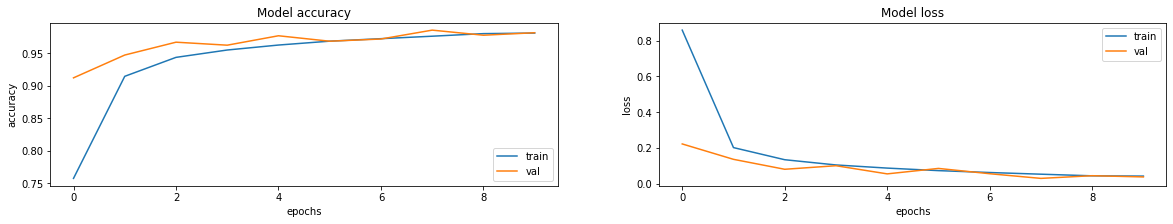

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate([ "accuracy", "loss"]):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

Real: 1694,
Fake: 1893



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


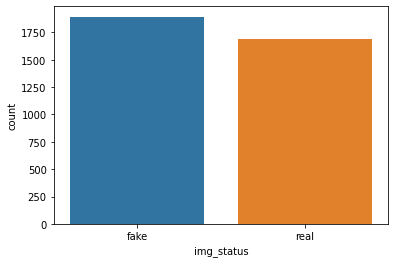

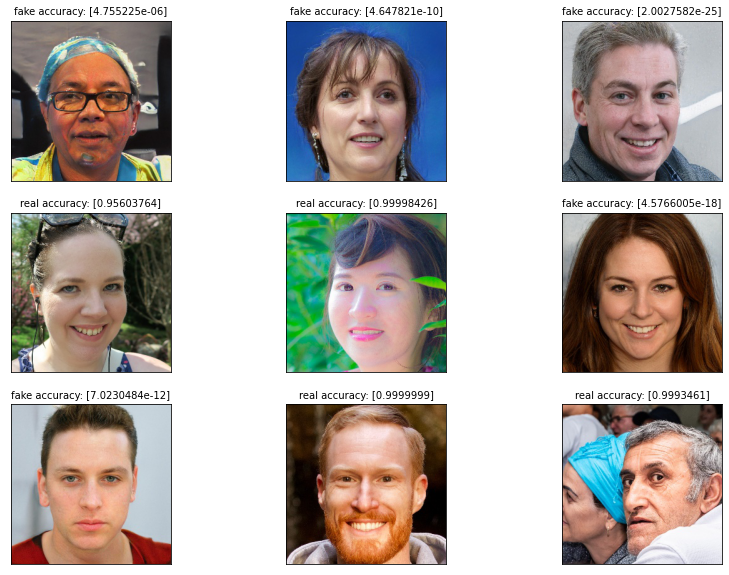

In [38]:
path  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/test'
test_dataset = load_dataset(path)
predict_dataset(test_dataset)